# Data reduction for IXS beamline at NSLS-II from data in specfiles

This notebook will walk you through all of the steps necessary for reducing the IXS data that comes from specfiles.  We start with raw data from the spec file and end up with aligned curves for:

- each detector
- all detectors summed in the same scan
- like-detectors summed across scans
- one final sum of all detectors in all scans

All of the plots and data generated in this notebook are saved to disk in the folder "align_output/scan_num1-scan_num2-scan_num3-..."

In [1]:
import fnmatch
import os
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import tempfile
from pprint import pformat, pprint

from ixstools.io import Specfile
from ixstools.fit import gaussian_fit

%matplotlib inline

## The next cell is the only place that you should *have* to modify parameters.  

After you modify these parameters, you should just be able to click "Cell -> Run All"; or if you are paranoid (like me), then you should do "Kernel -> Restart and Run All".  After all cells have run, go inspect the figure output!

In [2]:
# The path to the spec file location
path_to_specfiles = '../ixstools'
# the name of the specific spec file
specfile_name = '20160219.spec'
# name of the x axis
x_name = 'HRM_En'
# the name of the detector(s). Respects standard file globbing
y_names = 'TD*'
# the name of the monitor column
monitors = ['SRcur', 'PD11']
# the scans that you wish to process
scans = [20, 22]
# interpolation mode options are
# 'linear'
# 'nearest'
# 'zero'
# 'slinear'
# 'quadratic
# 'cubic'
# where 'slinear', 'quadratic' and 'cubic' refer to a spline interpolation
# of first, second or third order)
interpolation_mode = 'linear'
# The multiplicative factor to increase (>1) or decrease (<1) the interpolated
# axis
densify_interpolated_axis = 1
# Folder to write the data (respects relative and absolute paths).
# Defaults to 'align_output' folder in current directory
output_dir = 'align_output' + os.sep + '-'.join([str(s) for s in scans])
# The separator in the output files.
# Defaults to space: ' '
output_sep = ','
# Plot *all* plots with a log scale on the y axis.
# Defaults to True
logy = True

In [3]:
# Some helpful functions
def make_axes(num_axes, fig_width_factor=4, fig_height_factor=4):
    """Helper function to make a grid of axes with a specific size
    
    Parameters
    ----------
    num_axes : int or iterable
        int: The **total** number of axes
        iterable: (cols, rows)
    fig_width_factor : float, optional
        The figure width is num_cols * fig_width_factor
    fig_height_factor : float, optional
        The figure height is num_rows * fig_height_factor
    
    Returns
    -------
    fig : mpl.Figure
    ax : axes, array of axes or array of array of axes
        if num_axes == 1, then this is a single matplotlib axes object
        elif num_axes == 2, then this is an array of mpl axes
        else this is an array of arrays of mpl axes whose shape is (nrows, ncols)
    """
    try:
        ncols, nrows = num_axes
    except TypeError:
        ncols = nrows = 1
        if num_axes >= 2:
            ncols = 2
            nrows = int(np.ceil(num_axes/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(ncols*fig_width_factor, 
                                    nrows*fig_height_factor))
    return fig, ax
    

In [4]:
# Please don't mess with these unless you know what you are doing
plot_method_name = 'plot'
if logy:
    plot_method_name = 'semilogy'

data_plot_kws = dict(linestyle='', marker='o')

translucent_red_marker = dict(
    linestyle='None', 
    markersize=8, 
    # [r, g, b, alpha]
    markerfacecolor=[1, 0, 0, 0.5], 
    marker='o'
)
black_fit_line = dict(
    marker='',
    linewidth=4,
    color='k'
)

In [5]:
specfile = os.path.join(path_to_specfiles, specfile_name)
sf = Specfile(specfile)

### Look at the column names of a specific scan with the "col_names" attribute on a scan number

In [6]:
sf[19].col_names

['HRM_En',
 'H',
 'K',
 'L',
 'Epoch',
 'Seconds',
 'Monitor',
 'PD12',
 'PD13',
 'PD14',
 'PD21',
 'PD22',
 'PD23',
 'PD24',
 'PD31',
 'PD32',
 'PD33',
 'PD34',
 'PD41',
 'PD42',
 'PD43',
 'PD44',
 'PD51',
 'PD52',
 'TD1',
 'TD2',
 'TD3',
 'TD4',
 'TD5',
 'TD6',
 'SC1',
 'SRcur',
 'PD11',
 'Detector']

In [7]:
# make the output directory
os.makedirs(output_dir, exist_ok=True)
sf = Specfile(specfile)
exposure_time = {sid: np.average(sf[sid].scan_data.Seconds) for sid in scans}
metadata = {'exposure time': exposure_time}
# get the dataframes that we care about
# make sure all the scans have the columns that we care about
data = []
y_keys = {}
for sid in scans:
    specscan = sf[sid]
    if not set(monitors) < set(specscan.col_names):
        raise KeyError(
            '{} are the specified monitors and are not a complete subset '
            'of the available columns in scan {}. '
            'Column names in this scan are {} and {} are not in this scan'
            ''.format(monitors, sid, specscan.col_names,
                      set(monitors).intersection(specscan.col_names)))
    if x_name not in specscan.col_names:
        raise KeyError(
            '{} is the specified x axis and is not found in scan {}. '
            'Column names in this scan are {}'.format(
                x_name, sid, specscan.col_names))
    if '*' in y_names:
        # need to check to make sure that all the keys are in all the
        y_keys[sid] = fnmatch.filter(specscan.col_names, y_names)
    else:
        # set(A) < set(B) being True means that A is a subset of B
        # Make sure that all the keys that are specified in the config
        # are in the column names of the spec scan
        # pdb.set_trace()
        if not set(y_names) < set(specscan.col_names):
            raise KeyError(
                '{} are found in the config file under the "y:" section '
                'but are not found in scan {}'
                ''.format(set(y_keys[sid]).difference(specscan.col_names)))
if y_keys:
    keys = list(sorted(y_keys))
    for k1, k2 in zip(keys, keys[1:]):
        if y_keys[k1] != y_keys[k2]:
            print('Scans have different y keys.\nScan {}: {}\nScan{}: {}'
                  ''.format(k1, y_keys[v1], k2, y_keys[k2]))
    y_keys = y_keys[keys[0]]
else:
    y_keys = y_names


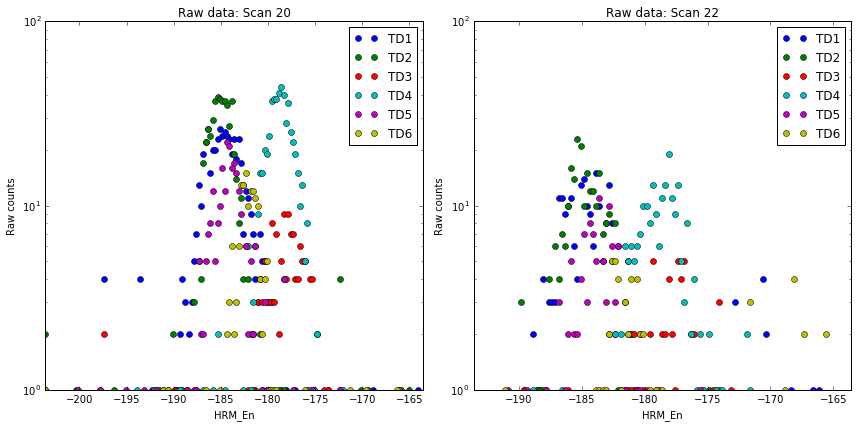

In [8]:
# looks like we made it through the gauntlet!
x_data = [sf[sid].scan_data[x_name] for sid in scans]
y_data = [sf[sid].scan_data[y_keys] for sid in scans]
# output the raw data and make some matplotlib plots
fig, axes = make_axes(len(y_data), 6, 6)
for x_vals, y_sid, sid, ax in zip(x_data, y_data, scans, axes.ravel()):
    fpath = os.path.join(output_dir, '%s-raw' % sid)
    df = y_sid.copy().set_index(x_vals)
    df.to_csv(fpath, output_sep)
    df.plot(logy=logy, ax=ax, **data_plot_kws)
    ax.set_title("Raw data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")

plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-raw')
fig.savefig(fpath + '.png')

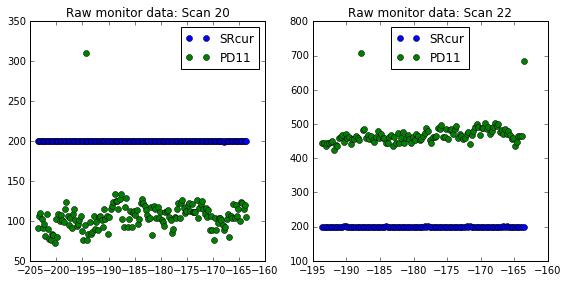

In [9]:
# Extract and plot the raw monitor columns
raw_monitor_data = [[sf[sid].scan_data[monitor] 
                     for monitor in monitors]
                    for sid in scans]
fig, axes = make_axes(len(raw_monitor_data))
for mon_data, x, sid, ax in zip(raw_monitor_data, x_data, scans, axes.ravel()):
    for d, mon in zip(mon_data, monitors):
        ax.plot(x, d, label=mon, **data_plot_kws)
#         ax.semilogy(x, d, label=mon)
    ax.legend(loc=0)
    ax.set_title('Raw monitor data: Scan %s' % sid)
plt.tight_layout()

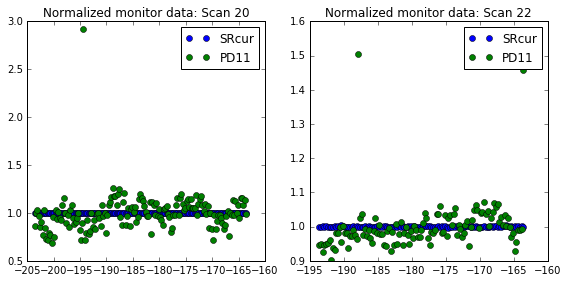

In [10]:
# normalize the monitor by its average value
norm_mon_data = [[d / np.average(d) for d in mon_data] for mon_data in raw_monitor_data]
fig, axes = make_axes(len(raw_monitor_data))
for mon_data, x, sid, ax in zip(norm_mon_data, x_data, scans, axes.ravel()):
    for d, mon in zip(mon_data, monitors):
        ax.plot(x, d, label=mon, **data_plot_kws)
    ax.legend(loc=0)
    ax.set_title('Normalized monitor data: Scan %s' % sid)
plt.tight_layout()

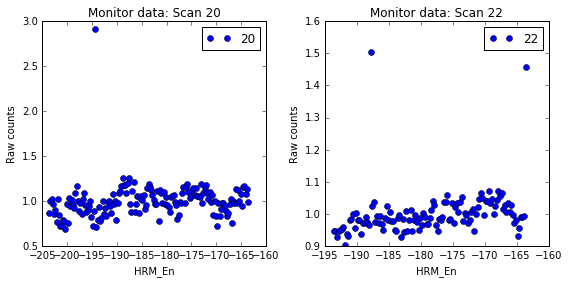

In [11]:
# normalize the monitor by its average value
monitor_data = [np.product(mon_data, axis=0) for mon_data in norm_mon_data]

fig, axes = make_axes(len(monitor_data))
for mon_data, x, sid, ax in zip(monitor_data, x_data, scans, axes.ravel()):
    ax.plot(x, mon_data, label=sid, **data_plot_kws)
    ax.legend(loc=0)
    ax.set_title("Monitor data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")
    # output the monitor data
    fpath = os.path.join(output_dir, '%s-monitor' % sid)
    pd.DataFrame({'sid': mon_data}, index=x).to_csv(fpath, output_sep)
    
plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-monitor')
fig.savefig(fpath + '.png')

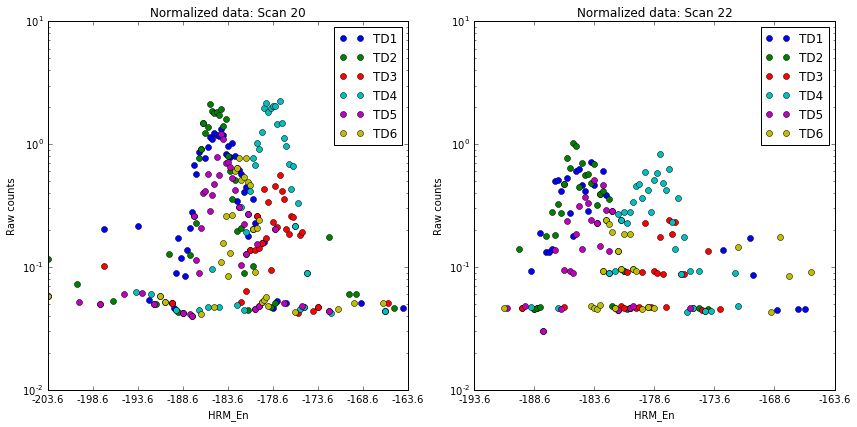

In [12]:
# normalize by the monitor
normed = [y.divide(monitor*ct_time, 'rows')
          for y, monitor, ct_time in zip(y_data, monitor_data, exposure_time)]
fig, axes = make_axes(len(normed), 6, 6)
for df, x, sid, ax in zip(normed, x_data, scans, axes.ravel()):
    df.plot(logy=logy, ax=ax, **data_plot_kws)
    ax.legend(loc=0)
    ax.set_title("Normalized data: Scan %s" % sid)
    ax.set_xlabel(x_name)
    ax.set_ylabel("Raw counts")
    # output the monitor data
    fpath = os.path.join(output_dir, '%s-norm' % sid)
    df.to_csv(fpath, output_sep)

plt.tight_layout()

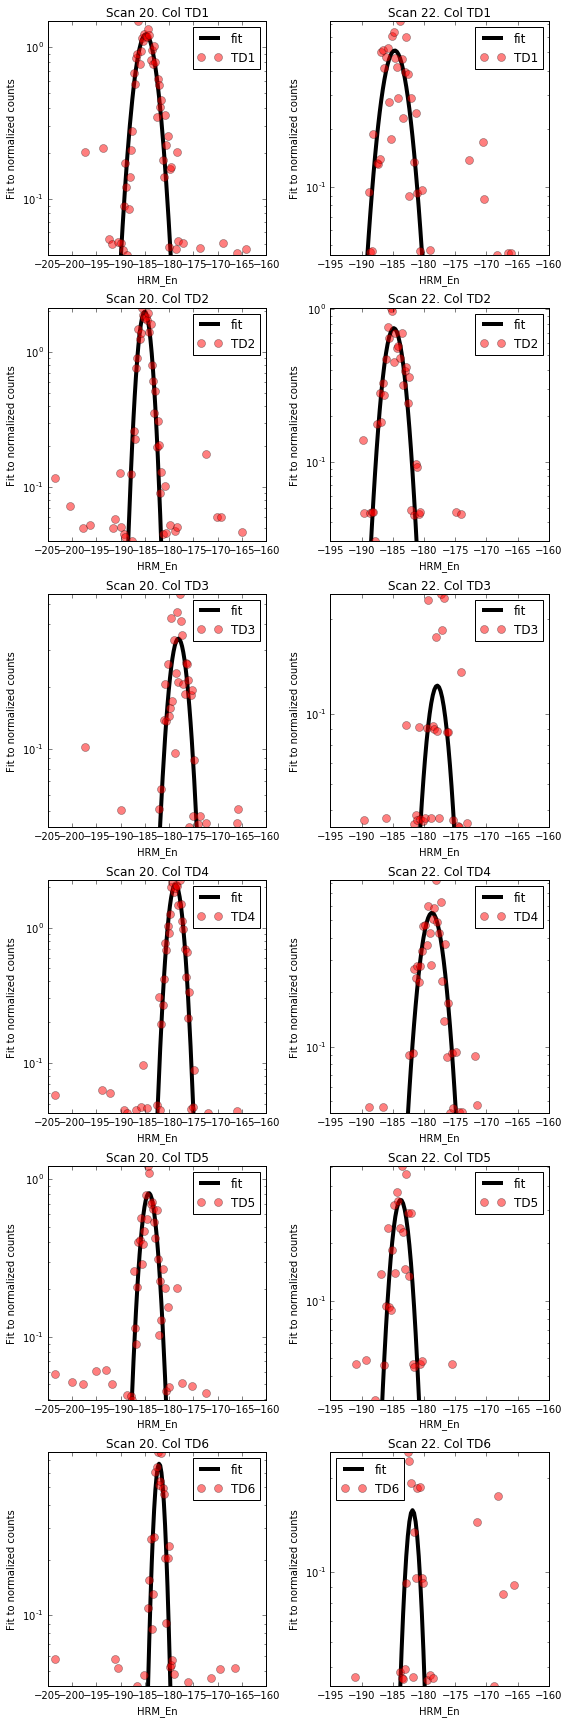

In [13]:
# fit all the data
fits = [[gaussian_fit(x, cols[col_name]) for col_name in cols]
        for x, cols in zip(x_data, normed)]
metadata['fits'] = {}
# output the fit data


fig, axes = plt.subplots(nrows=len(y_keys), ncols=len(scans), figsize=(len(scans)*4, len(y_keys)*4))

for x_vals, normed_df, fit_output, sid, ax_col in zip(x_data, normed, fits, scans, axes.T):
    df_dict = {col_name: f.best_fit.values for col_name, f in zip(y_keys, fit_output)}
    df = pd.DataFrame(df_dict, index=x_vals)
    for ax, fit_col_name, normed_col_name in zip(ax_col, df, normed_df):
        plot = getattr(ax, plot_method_name)
        fit = plot(df.index, df[fit_col_name], label='fit', 
                   **black_fit_line)
        d, = plot(normed_df.index, normed_df[normed_col_name], 
                  label=normed_col_name, **translucent_red_marker)
        # manually set the marker face color so that I can set the alpha
        curmax = np.max(normed_df[normed_col_name])
        curmin = normed_df[normed_col_name].dropna()[normed_df[normed_col_name] != 0].min()
        ax.set_ylim([curmin, curmax])
        ax.legend(loc=0)
        ax.set_title('Scan %s. Col %s' % (sid, normed_col_name))
        ax.set_xlabel(x_name)
        ax.set_ylabel("Fit to normalized counts")
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'fit']))
    df.to_csv(fpath, output_sep)
    metadata['fits'][sid] = {
        col_name: f.fit_report() for col_name, f in zip(y_keys, fit_output)
    }
plt.tight_layout()
# write metadata to file
fname = '-'.join([str(sid) for sid in scans]) + 'metadata'
with open(os.path.join(output_dir,  fname), 'w') as f:
    f.write(pformat(metadata))
    
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-fit')
fig.savefig(fpath + '.png')

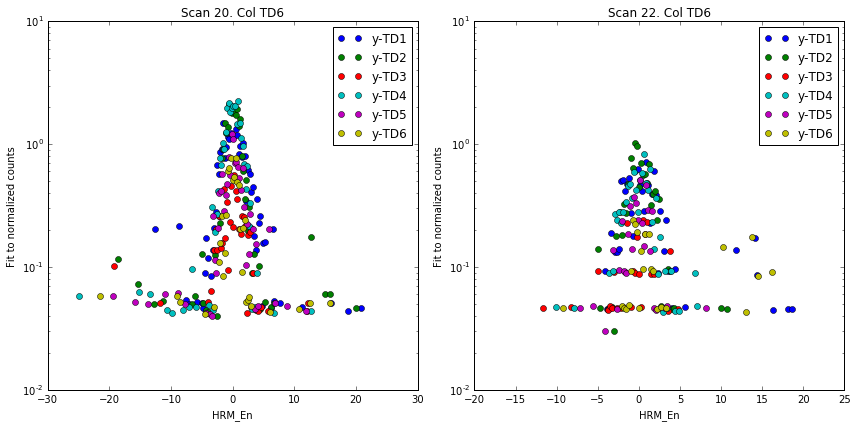

In [14]:
# zero everything
zeroed = [
    [(np.array(f.userkws['x'] - f.params['center'], dtype=float), f.data)
     for f in fit] for fit in fits]
# output the zeroed data
fig, axes = make_axes(len(zeroed), 6, 6)
for zeroed_vals, sid, ax in zip(zeroed, scans, axes.ravel()):
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'zeroed']))
    col_names = [['x-%s' % col_name, 'y-%s' % col_name] for col_name in y_keys]
    df_dict = {col_name: col
               for col_name_pair, xy in zip(col_names, zeroed_vals)
               for col_name, col in zip(col_name_pair, xy)}
    df = pd.DataFrame(df_dict)
    plot = getattr(ax, plot_method_name)
    for x, y in col_names:
        plot(df[x], df[y], label=y, **data_plot_kws)
    ax.set_title('Scan %s. Col %s' % (sid, normed_col_name))
    ax.set_xlabel(x_name)
    ax.set_ylabel("Fit to normalized counts")
    ax.legend(loc=0)
#     df.plot(ax=ax, logy=logy)
    df.to_csv(fpath, output_sep)

plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-aligned')
fig.savefig(fpath + '.png')

## Make the new interpolated axis

In [15]:
# compute the average difference between data points
diff = np.average([np.average([np.average(np.diff(x)) for x, y in z]) for z in zeroed])
stepsize = diff / densify_interpolated_axis
minval = np.max([np.min([x for x, y in xy]) for xy in zeroed])
maxval = np.max([np.max([x for x, y in xy]) for xy in zeroed])
# round down to the lower integer
minval = np.floor(minval)
# round up to the nearest integer
maxval = np.ceil(maxval)
# compute the new axes
new_axis = np.arange(minval, maxval, stepsize)
print('min, max, step: (%s, %s, %s)' % (minval, maxval, stepsize))

min, max, step: (-16.0, 22.0, 0.25)


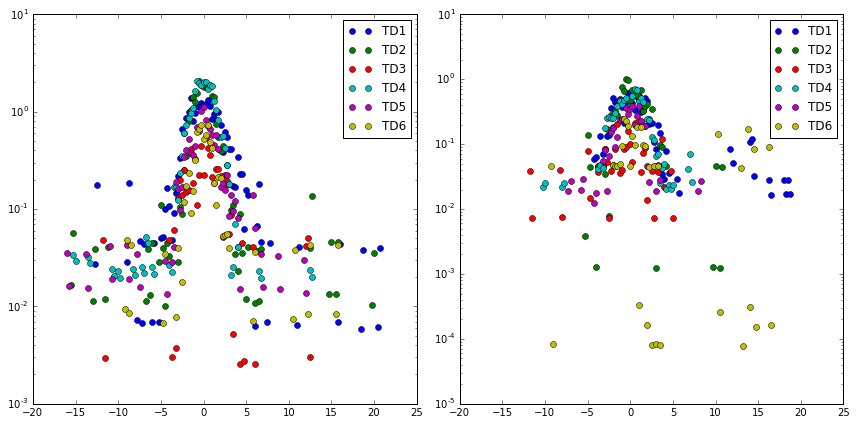

In [16]:
# set up the interpolators
interpolators = [[interp1d(x, y, kind=interpolation_mode,
                           bounds_error=False,
                           fill_value=np.nan)
                  for x, y in z] for z in zeroed]

# Create the interpolated va`lues categorized by scan
interpolated = [
    pd.DataFrame({col_name: interp(new_axis) for col_name, interp in
                  zip(y_keys, interpolator)},
                 index=new_axis) for interpolator in interpolators]

fig, axes = make_axes((2, 1), 6, 6)
# output and plot the interpolated data
for interp_df, sid, ax in zip(interpolated, scans, axes.ravel()):
    fpath = os.path.join(output_dir, '-'.join([str(sid), 'interpolated']))
    interp_df.to_csv(fpath, output_sep)
    plot = getattr(ax, plot_method_name)
    for col in interp_df:
        plot(interp_df.index, interp_df[col], label=col, 
             **data_plot_kws)
    ax.legend(loc=0)
plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-interpolated')
fig.savefig(fpath + '.png')

FWHM for 20: 3.344 +/- 0.033
FWHM for 22: 3.823 +/- 0.078


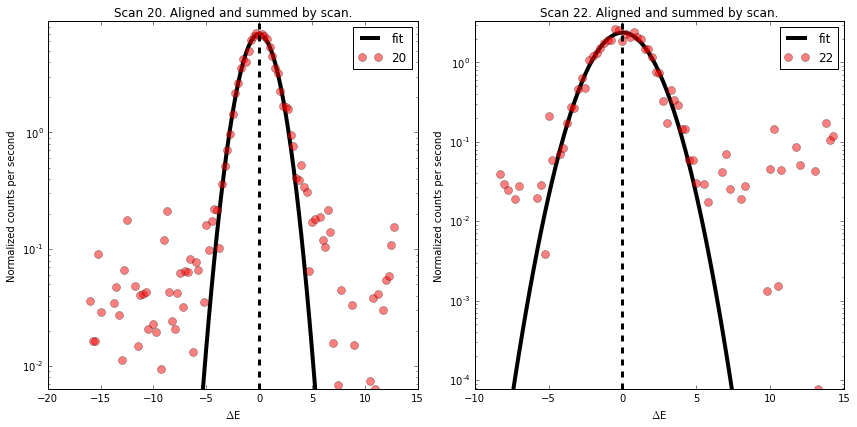

In [17]:
summed_by_scan = pd.DataFrame({
    sid: interp_df.dropna().sum(axis=1)
    for sid, interp_df in zip(scans, interpolated)}, index=new_axis)
# fit the summed by scan curves
# pdb.set_trace()
summed_by_scan_fit = {}
fits = {}
for sid in summed_by_scan:
    series = summed_by_scan[sid].dropna()
    f = gaussian_fit(series.index.values, series.values)
    fits[sid] = f
    summed_by_scan_fit[sid] = pd.DataFrame({sid: f.best_fit}, index=series.index.values)
    print('FWHM for %s: %.4g +/- %.2g' % (sid, f.params['fwhm'].value, f.params['fwhm'].stderr))

fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans] + ['summed']))
with open(fpath+'-by-scan-FIT', 'w') as f:
    for sid, fit in fits.items():
        f.write('Scan %s\n' % sid)
        f.write(fit.fit_report())
        f.write('\n\n')
# Output the summed by scan data
summed_by_scan.to_csv(fpath + '-by-scan', output_sep)
# plot the data summed by scan

fig, axes = make_axes(len(scans), 6, 6)
for sid, ax in zip(scans, axes.ravel()):
    plot = getattr(ax, plot_method_name)
    plot(summed_by_scan_fit[sid].index[:], summed_by_scan_fit[sid][:], label='fit', **black_fit_line)
    plot(summed_by_scan[sid].index[:], summed_by_scan[sid][:], label=sid, **translucent_red_marker)
    curmax = np.max(summed_by_scan[sid].max()) * 1.25
    curmin = np.min(summed_by_scan[sid][summed_by_scan[sid]!=0].min())
    ax.legend(loc=1)
    ax.set_title('Scan %s. Aligned and summed by scan.' % sid)
    ax.set_xlabel(r'$\Delta$E')
    ax.set_ylim([curmin, curmax])
    ax.set_ylabel("Normalized counts per second")
    ax.axvline(linewidth=3, color='k', linestyle='--')

plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-aligned-and-summed-by-scan')
fig.savefig(fpath + '.png')

FWHM for TD1: 4.667 +/- 0.11
FWHM for TD2: 3.001 +/- 0.056
FWHM for TD3: 4.361 +/- 0.22
FWHM for TD4: 3.336 +/- 0.041
FWHM for TD5: 3.312 +/- 0.089
FWHM for TD6: 2.44 +/- 0.09


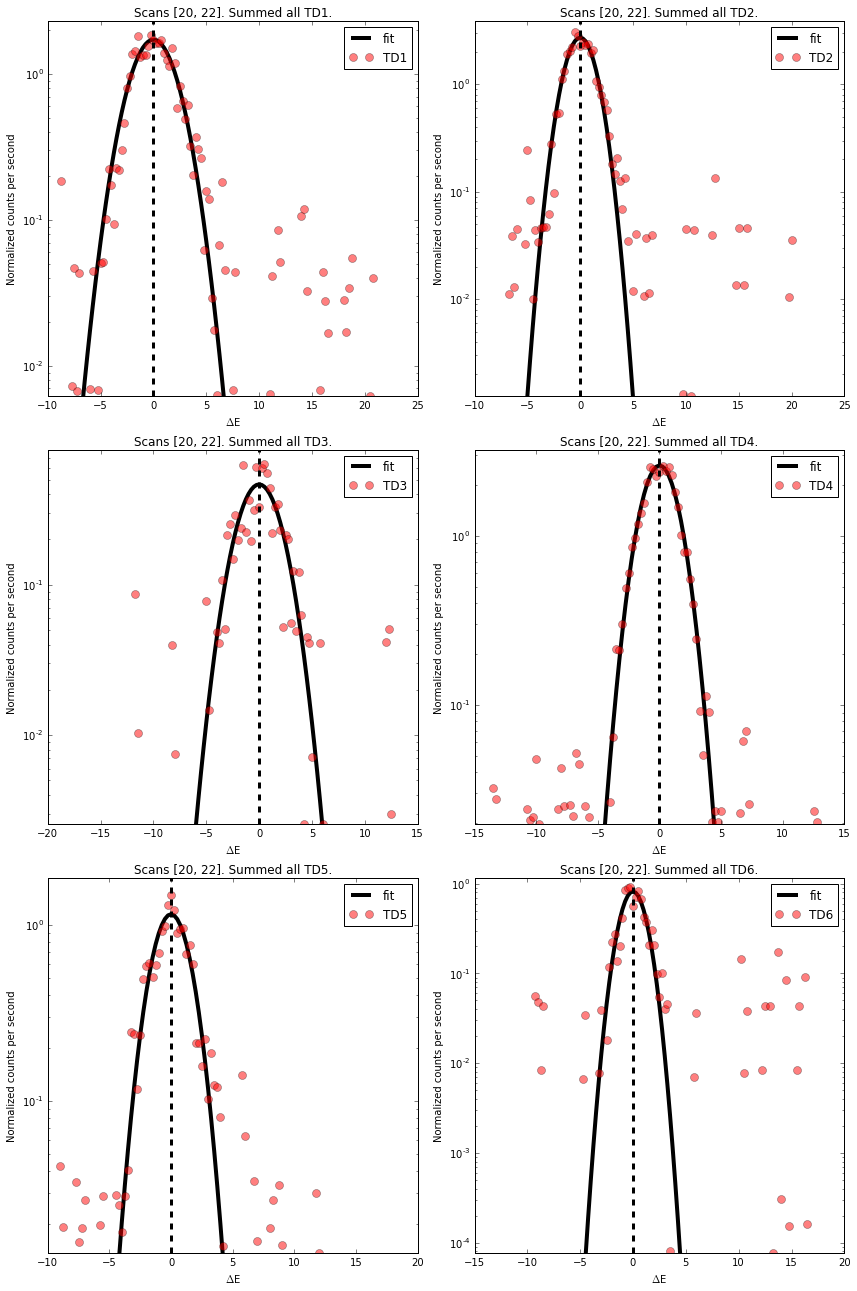

In [18]:

summed_by_detector = pd.DataFrame({
    det_name: np.sum([df[det_name].values for df in interpolated], axis=0)
    for det_name in list(y_data[0].columns)}, index=new_axis)
# Output the summed by scan data
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans] + ['summed']))
summed_by_detector.to_csv(fpath + '-by-detector', output_sep)


summed_by_detector_fit = {}
fits = {}
for det_name in summed_by_detector:
    series = summed_by_detector[det_name].dropna()
    f = gaussian_fit(series.index.values, series.values)
    fits[det_name] = f
    summed_by_detector_fit[det_name] = pd.DataFrame({det_name: f.best_fit}, index=series.index.values)
    print('FWHM for %s: %.4g +/- %.2g' % (det_name, f.params['fwhm'].value, f.params['fwhm'].stderr))

with open(fpath+'-by-detector-FIT', 'w') as f:
    for sid, fit in fits.items():
        f.write('Scan %s\n' % sid)
        f.write(fit.fit_report())
        f.write('\n\n')


fig, axes = make_axes(len(summed_by_detector.columns), 6, 6)

for col_name, ax in zip(summed_by_detector, axes.ravel()):
    plot = getattr(ax, plot_method_name)
    plot(summed_by_detector_fit[col_name].index[:], 
         summed_by_detector_fit[col_name][:], 
         label='fit', 
         **black_fit_line)
    plot(summed_by_detector[col_name].index[:], 
         summed_by_detector[col_name][:], 
         label=col_name, 
         **translucent_red_marker)
    curmax = np.max(summed_by_detector[col_name].max()) * 1.25
    curmin = np.min(summed_by_detector[col_name][summed_by_detector[col_name]!=0].min())
    ax.legend(loc=1)
    ax.set_title('Scans {}. Summed all {}.'.format(scans, col_name))
    ax.set_xlabel(r'$\Delta$E')
    ax.set_ylim([curmin, curmax])
    ax.set_ylabel("Normalized counts per second")
    ax.axvline(linewidth=3, color='k', linestyle='--')
plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-aligned-and-summed-by-detector')
fig.savefig(fpath + '.png')

FWHM for summed data set: 3.475 +/- 0.037


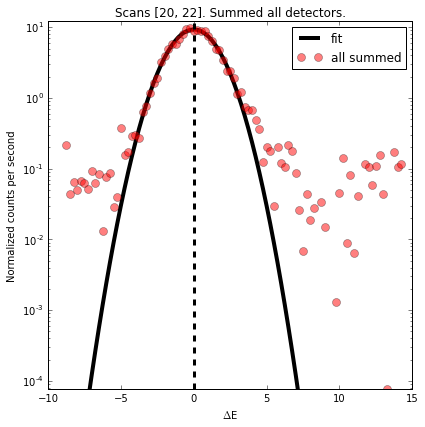

In [19]:
# make data set for summing all data

summed_all = summed_by_detector.dropna().sum(axis=1)
fit = gaussian_fit(summed_all.index.values, summed_all.values)
df =  pd.DataFrame({'data': summed_all.values, 'fit': fit.best_fit}, index=summed_all.index.values)
print('FWHM for summed data set: %.4g +/- %.2g' % (fit.params['fwhm'].value, fit.params['fwhm'].stderr))
# Output the summed by scan data
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans] + ['summed']))
df.to_csv(fpath + '-all-with-fit', output_sep)
with open(fpath + '-all-fit', 'w') as f:
    f.write(fit.fit_report())

# plot the final data and its fit

fig, ax = make_axes(1, 6, 6)
plot = getattr(ax, plot_method_name)
plot(df.index[:], df['fit'][:], label='fit', **black_fit_line)
plot(df.index[:], df['data'][:], label='all summed', **translucent_red_marker)
curmax = np.max(df['data'].max()) * 1.25
curmin = np.min(df['data'][df['data']!=0].min())
ax.legend(loc=1)
ax.set_title('Scans {}. Summed all detectors.'.format(scans))
ax.set_xlabel(r'$\Delta$E')
ax.set_ylim([curmin, curmax])
ax.set_ylabel("Normalized counts per second")
ax.axvline(linewidth=3, color='k', linestyle='--')
plt.tight_layout()
fpath = os.path.join(output_dir, '-'.join([str(sid) for sid in scans]) + '-aligned-and-summed-by-all')
fig.savefig(fpath + '.png')